# Inner model attemp


## 1. Files included: 
    # Immune
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "IRF7+_DCs": "Immune",
    "LAMP3+_DCs": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "Mast_Cells": "Immune",


    # Tumor
    "Prolif_Invasive_Tumor": "Tumor",
    "Invasive_Tumor": "Tumor",

    #early stage cancer
    "DCIS_1": "Early stage cancer",
    "DCIS_2": "Early stage cancer",

    # Connective tissue
    "Stromal": "Connective tissue",
    "Perivascular-Like": "Connective tissue",
    "Myoepi_ACTA2+": "Connective tissue",
    "Myoepi_KRT15+": "Connective tissue",

    #endothelial
    "Endothelial": "Endothelial",

## Files not included

    #hybrids
    "Stromal_and_T_Cell_Hybrid": "Hybrid",
    "T_Cell_and_Tumor_Hybrid": "Hybrid",

    # Unlabeled
    "Unlabeled": "Unlabeled"

### Tumor and early stage combined to make cancer file and others non-cancer

### Getting 2000 images total, so 1000 cancer and 1000 non-cancer. For cancer: 500 tumor and 500 early stage. For non-cancer: 333 connective, 333 endothelial and 334 immune

In [9]:
# Cell 1: Imports
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
random.seed(42)

# Cell 2: Load Metadata
# Assuming your coordinate file is similar to this
cbr = pd.read_csv("metadata_code/cbr.csv")  # Contains 'index', 'axis-0', 'axis-1'
# Folder structure under 'final_data' like: Immune/, Tumor/, Early stage cancer/, Connective tissue/, Endothelial/
base_image_dir = "final_data"

# Cell 3: Mapping Folders to Categories
# Map folder names to a 'category' label
category_folder_map = {
    "Tumor": "Cancer",
    "Early stage cancer": "Cancer",
    "Connective tissue": "Non-Cancer",
    "Endothelial": "Non-Cancer",
    "Immune": "Non-Cancer"
}

# Cell 4: Build Full Metadata
all_images = []

for folder_name in os.listdir(base_image_dir):
    folder_path = os.path.join(base_image_dir, folder_name)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            if img_name.endswith(".png") or img_name.endswith(".jpg"):
                img_id = img_name.split('.')[0]  # Assuming filenames are like cell_123_100.png or similar
                all_images.append({
                    "folder": folder_name,
                    "file_name": img_name,
                    "path": os.path.join(folder_path, img_name),
                    "category_type": category_folder_map[folder_name],
                    "specific_category": folder_name
                })

df_images = pd.DataFrame(all_images)

# Merge coordinates
# Assuming 'index' from cbr is matching with the image ids in some way
# Here, fix if needed (may need to strip "cell_" etc from filename)

cbr['index'] = cbr['index'].astype(str)
df_images['img_index'] = df_images['file_name'].str.extract(r'(\d+)')
df = pd.merge(df_images, cbr, left_on='img_index', right_on='index')

print(f"Total images with coordinates: {len(df)}")

# Cell 5: Define Quadrants
x_mid = df["axis-1"].median()
y_mid = df["axis-0"].median()

def get_quadrant(row):
    if row["axis-1"] < x_mid and row["axis-0"] < y_mid:
        return "Q1"  # Top-left
    elif row["axis-1"] >= x_mid and row["axis-0"] < y_mid:
        return "Q2"  # Top-right
    elif row["axis-1"] < x_mid and row["axis-0"] >= y_mid:
        return "Q3"  # Bottom-left
    else:
        return "Q4"  # Bottom-right

df["quadrant"] = df.apply(get_quadrant, axis=1)

# Cell 6: Sampling the Correct Numbers
# Cancer: 500 Tumor + 500 Early Stage
tumor = df[df['specific_category'] == "Tumor"].sample(500, random_state=42)
early_stage = df[df['specific_category'] == "Early stage cancer"].sample(500, random_state=42)

# Non-Cancer: 333 Connective + 333 Endothelial + 334 Immune
connective = df[df['specific_category'] == "Connective tissue"].sample(333, random_state=42)
endothelial = df[df['specific_category'] == "Endothelial"].sample(333, random_state=42)
immune = df[df['specific_category'] == "Immune"].sample(334, random_state=42)

# Combine
final_df = pd.concat([tumor, early_stage, connective, endothelial, immune])
print(f"Total sampled images: {len(final_df)}")

# Cell 7: Quadrant Balancing
# Now ensure each quadrant has ~250 images proportionally

# Split per quadrant
quadrant_groups = final_df.groupby('quadrant')

balanced_samples = []
for quadrant, group in quadrant_groups:
    cancer_samples = group[group['category_type'] == "Cancer"]
    non_cancer_samples = group[group['category_type'] == "Non-Cancer"]

    n_total = 250  # target for each quadrant
    n_cancer = int(n_total * 0.5)  # ~50%
    n_non_cancer = n_total - n_cancer

    sampled_cancer = cancer_samples.sample(min(n_cancer, len(cancer_samples)), random_state=42)
    sampled_non_cancer = non_cancer_samples.sample(min(n_non_cancer, len(non_cancer_samples)), random_state=42)

    balanced_samples.append(pd.concat([sampled_cancer, sampled_non_cancer]))

final_balanced_df = pd.concat(balanced_samples)
print(f"Final images after quadrant balancing: {len(final_balanced_df)}")

# Cell 8: Final Outputs
# Save the mapping
final_balanced_df[['path', 'folder', 'file_name', 'category_type', 'specific_category', 'quadrant']].to_csv("quadrant_assignment.csv", index=False)

print("Saved 'quadrant_assignment.csv' successfully.")

# Optional: Display quadrant counts
print(final_balanced_df['quadrant'].value_counts())
print(final_balanced_df.groupby(['quadrant', 'category_type']).size())


Total images with coordinates: 212115
Total sampled images: 2000
Final images after quadrant balancing: 1000
Saved 'quadrant_assignment.csv' successfully.
quadrant
Q1    250
Q2    250
Q3    250
Q4    250
Name: count, dtype: int64
quadrant  category_type
Q1        Cancer           125
          Non-Cancer       125
Q2        Cancer           125
          Non-Cancer       125
Q3        Cancer           125
          Non-Cancer       125
Q4        Cancer           125
          Non-Cancer       125
dtype: int64


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the file that we created before
df = pd.read_csv("quadrant_assignment.csv")

# Split quadrants
train_val_df = df[df['quadrant'].isin(['Q1', 'Q2', 'Q3'])]  # Training + Validation quadrants
test_df = df[df['quadrant'] == 'Q4']                        # Testing quadrant

# Now split train_val_df into train and validation
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['category_type'])

# Check the sizes
print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")
print(f"Testing images: {len(test_df)}")

# Save these splits if you want
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print("Saved 'train_split.csv', 'val_split.csv', 'test_split.csv' successfully.")


Training images: 600
Validation images: 150
Testing images: 250
Saved 'train_split.csv', 'val_split.csv', 'test_split.csv' successfully.


In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# --- Step 1: Load the CSVs ---
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
test_df = pd.read_csv("test_split.csv")

# --- Step 2: Image Data Generators ---
# Basic data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Step 3: Flow from dataframe ---
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# --- Step 4: Build VGG19 Model ---
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary output (Cancer vs Non-Cancer)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Step 5: Compile ---
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Step 6: Train ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

# --- Step 7: Evaluate on Test ---
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Found 600 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


Epoch 1/20
19/19 [==============================] - 197s 10s/step - loss: 0.7217 - accuracy: 0.5217 - val_loss: 0.6494 - val_accuracy: 0.7200
Epoch 2/20
19/19 [==============================] - 194s 10s/step - loss: 0.6778 - accuracy: 0.5833 - val_loss: 0.6161 - val_accuracy: 0.7267
Epoch 3/20
19/19 [==============================] - 191s 10s/step - loss: 0.6742 - accuracy: 0.5883 - val_loss: 0.5930 - val_accuracy: 0.7467
Epoch 4/20
19/19 [==============================] - 187s 10s/step - loss: 0.6223 - accuracy: 0.6533 - val_loss: 0.5706 - val_accuracy: 0.7533
Epoch 5/20
19/19 [==============================] - 185s 10s/step - loss: 0.6037 - accuracy: 0.6833 - val_loss: 0.5517 - val_accuracy: 0.7533
Epoch 6/20
19/19 [==============================] - 190s 10s/step - loss: 0.5828 - accuracy: 0.6900 - val_loss: 0.5392 - val_accuracy: 0.7533
Epoch 7/20
19/19 [==============================] - 194s 10s/step - loss: 0.5742 - accuracy: 0.7067 - val_loss: 0.5286 - val_accuracy: 0.7533
Epoch 

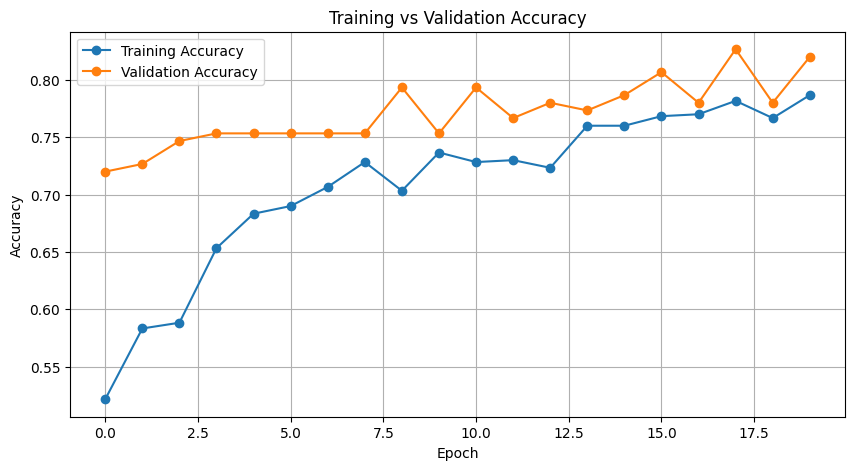

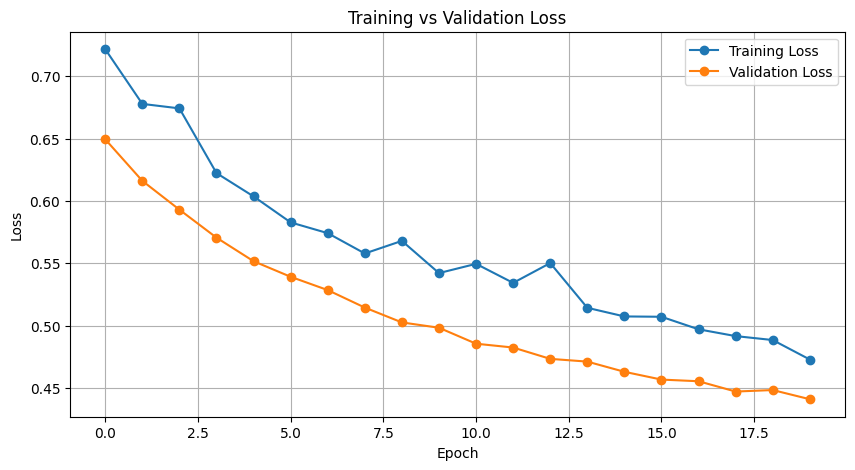

In [6]:
import matplotlib.pyplot as plt

# --- Step 1: Get History Data ---
# Assuming your training code was like:
# history = model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS, ...)

# --- Step 2: Plot Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 3: Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


8/8 [==============================] - 61s 8s/step


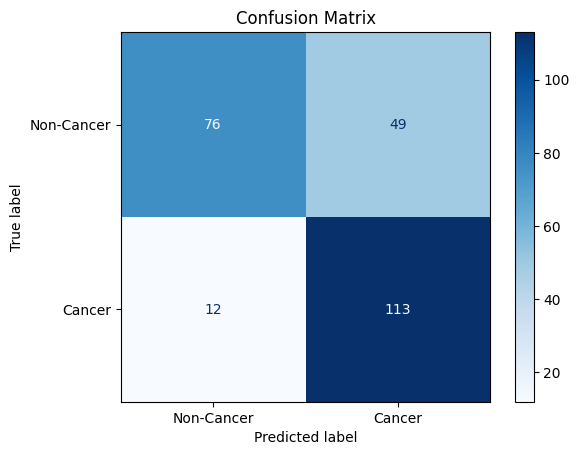

Classification Report:
              precision    recall  f1-score   support

  Non-Cancer       0.86      0.61      0.71       125
      Cancer       0.70      0.90      0.79       125

    accuracy                           0.76       250
   macro avg       0.78      0.76      0.75       250
weighted avg       0.78      0.76      0.75       250



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Step 1: Predict on test data ---
# Get model predictions
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Threshold 0.5 for binary classification

# Get true labels
y_true = test_generator.classes  # Already ordered correctly since shuffle=False

# --- Step 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cancer", "Cancer"])

# --- Step 3: Plot Confusion Matrix ---
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# --- Step 4: Extra: Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Cancer", "Cancer"]))


## Data augmentation and fine tuning

In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# --- Step 1: Load the CSVs ---
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
test_df = pd.read_csv("test_split.csv")

# --- Step 2: Image Data Generators ---
# Boosted augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Step 3: Flow from dataframe ---
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# --- Step 4: Build VGG19 Model ---
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Step 5: Compile (Initial Training) ---
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Step 6: Train Top Layers ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

# --- Step 7: Fine-tuning ---
# Unfreeze last few layers of VGG19 for fine-tuning
for layer in base_model.layers[-8:]:  # Unfreeze last 8 layers
    layer.trainable = True

# Recompile with LOWER learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

# --- Step 8: Evaluate on Test ---
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Found 600 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


Epoch 1/10
19/19 [==============================] - 221s 12s/step - loss: 0.7468 - accuracy: 0.4800 - val_loss: 0.6723 - val_accuracy: 0.6800
Epoch 2/10
19/19 [==============================] - 370s 20s/step - loss: 0.6819 - accuracy: 0.5633 - val_loss: 0.6407 - val_accuracy: 0.6733
Epoch 3/10
19/19 [==============================] - 432s 23s/step - loss: 0.6897 - accuracy: 0.5600 - val_loss: 0.6080 - val_accuracy: 0.8000
Epoch 4/10
19/19 [==============================] - 421s 22s/step - loss: 0.6469 - accuracy: 0.6300 - val_loss: 0.5833 - val_accuracy: 0.8067
Epoch 5/10
19/19 [==============================] - 405s 21s/step - loss: 0.6180 - accuracy: 0.6550 - val_loss: 0.5668 - val_accuracy: 0.7400
Epoch 6/10
19/19 [==============================] - 358s 19s/step - loss: 0.6145 - accuracy: 0.6667 - val_loss: 0.5452 - val_accuracy: 0.8000
Epoch 7/10
19/19 [==============================] - 201s 11s/step - loss: 0.6124 - accuracy: 0.6617 - val_loss: 0.5329 - val_accuracy: 0.7667
Epoch 

Epoch 1/20
19/19 [==============================] - 292s 15s/step - loss: 0.4948 - accuracy: 0.7767 - val_loss: 0.4005 - val_accuracy: 0.8267
Epoch 2/20
19/19 [==============================] - 286s 15s/step - loss: 0.4958 - accuracy: 0.7650 - val_loss: 0.4015 - val_accuracy: 0.8133
Epoch 3/20
19/19 [==============================] - 287s 15s/step - loss: 0.4495 - accuracy: 0.7733 - val_loss: 0.3701 - val_accuracy: 0.8467
Epoch 4/20
19/19 [==============================] - 285s 15s/step - loss: 0.4479 - accuracy: 0.8000 - val_loss: 0.3737 - val_accuracy: 0.8467
Epoch 5/20
19/19 [==============================] - 290s 15s/step - loss: 0.4270 - accuracy: 0.8133 - val_loss: 0.3742 - val_accuracy: 0.8467
Epoch 6/20
19/19 [==============================] - 296s 16s/step - loss: 0.4322 - accuracy: 0.8033 - val_loss: 0.3669 - val_accuracy: 0.8533
Epoch 7/20
19/19 [==============================] - 283s 15s/step - loss: 0.4188 - accuracy: 0.8050 - val_loss: 0.3681 - val_accuracy: 0.8333
Epoch 

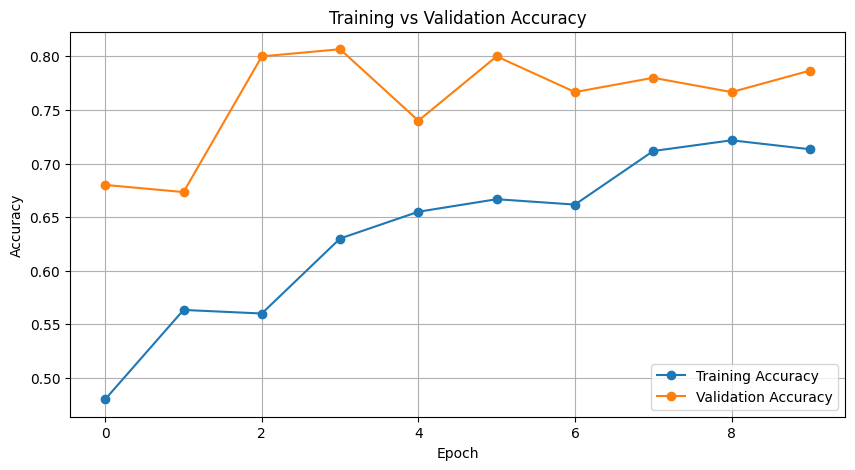

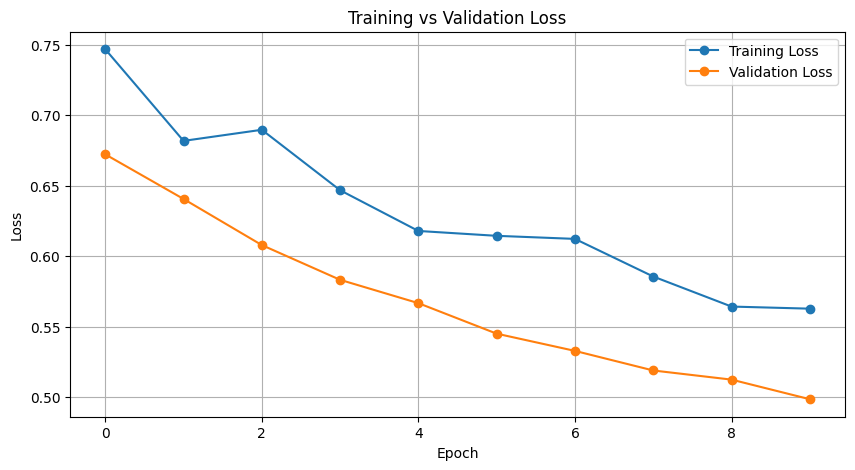

In [11]:
import matplotlib.pyplot as plt

# --- Step 1: Get History Data ---
# Assuming your training code was like:
# history = model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS, ...)

# --- Step 2: Plot Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 3: Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


8/8 [==============================] - 70s 9s/step


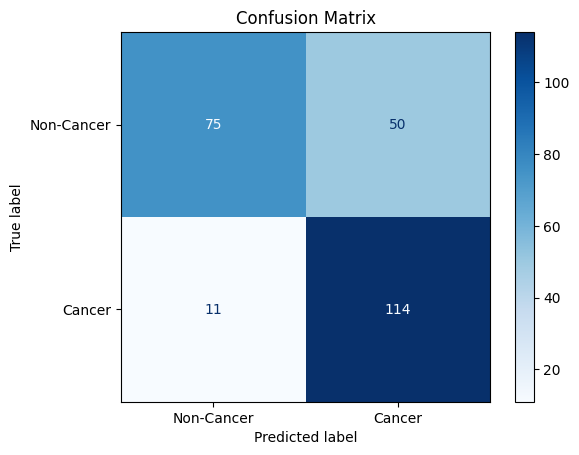

Classification Report:
              precision    recall  f1-score   support

  Non-Cancer       0.87      0.60      0.71       125
      Cancer       0.70      0.91      0.79       125

    accuracy                           0.76       250
   macro avg       0.78      0.76      0.75       250
weighted avg       0.78      0.76      0.75       250



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Step 1: Predict on test data ---
# Get model predictions
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Threshold 0.5 for binary classification

# Get true labels
y_true = test_generator.classes  # Already ordered correctly since shuffle=False

# --- Step 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cancer", "Cancer"])

# --- Step 3: Plot Confusion Matrix ---
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# --- Step 4: Extra: Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Cancer", "Cancer"]))